# 🧩 Проект: Прогноз оттока клиентов компании «ТелеДом»

# 🎯 Цель
Построить модель, которая предсказывает, разорвёт ли клиент договор с оператором связи.  
Результаты помогут выявлять клиентов, склонных к оттоку, и снижать потери компании.

---

# 📋 План работы
- Загрузка и объединение данных из разных источников.  
- Предобработка данных 
- Исследовательский анализ данных (EDA) и визуализация зависимостей.  
- Разделение данных на обучающую и тестовую выборки.  
- Обучение и сравнение моделей.  
- Оценка качества по метрике **ROC-AUC**.  
- Выбор лучшей модели и формулировка выводов.

---

In [1]:
pip install phik

Note: you may need to restart the kernel to use updated packages.


In [2]:
import warnings
warnings.filterwarnings('ignore')

## Импорт библиотек

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import phik
from phik.report import plot_correlation_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Загрузка данных и объединение данных

### Загрузка файлов

In [4]:
cn = pd.read_csv("/datasets/contract_new.csv")
pn = pd.read_csv("/datasets/personal_new.csv")
inter_n = pd.read_csv("/datasets/internet_new.csv")
ph_n = pd.read_csv("/datasets/phone_new.csv")

In [5]:
cn.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


In [6]:
pn.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [7]:
inter_n.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [8]:
ph_n.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


**Комментарий**: Данные соответствуют описанию.

### Объединение

In [9]:
data = cn.merge(pn, on='customerID', how='left').merge(inter_n, on='customerID', how="left").merge(ph_n, on='customerID', how="left")

## Предобработка данных

### Проверка типов данных на соответсвие данным

In [10]:
data.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 


**Комментарий**: Столбцы `BeginDate` и `EndDate`надо привести к формату `datetime`, в `EndData` также дополнительно надо обработать значения `No`, заменив их на `Nan`. Столбец `TotalCharges` имеет некорректный тип данных `object`, заменим его на `float`. В столбце `MultipleLines` значения `Nan` скорее всего означают отсутствие телефона, поэтому заменим эти значения просто на `No service`. Также кол-во данных из файла `internet_new.csv` сильно меньше чем пользователей в таблице, далее мы более подробно рассмотрим этот кусок таблицы

In [12]:
data['BeginDate'] = pd.to_datetime(data['BeginDate'])
data['EndDate'] = data['EndDate'].replace('No', np.nan)
data['EndDate'] = pd.to_datetime(data['EndDate'])
data[['BeginDate', 'EndDate']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   BeginDate  7043 non-null   datetime64[ns]
 1   EndDate    1101 non-null   datetime64[ns]
dtypes: datetime64[ns](2)
memory usage: 165.1 KB


**Комментарий**: Теперь даты в правильном формате и вместо `No` у нас значения `Nan` в столбце `EndDate`.

In [13]:
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')
data[['TotalCharges']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   TotalCharges  7032 non-null   float64
dtypes: float64(1)
memory usage: 110.0 KB


**Комментарий**: Теперь и в столбце `TotalCherges` корректный тип данных, также в процессе перевода типа данных было обнаружено `11` пропусков по этому признаку

In [14]:
data['MultipleLines'] = data['MultipleLines'].fillna('No service')
data['MultipleLines'].unique()

array(['No service', 'No', 'Yes'], dtype=object)

In [15]:
data[['MultipleLines']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MultipleLines  7043 non-null   object
dtypes: object(1)
memory usage: 110.0+ KB


**Комментарий**: Теперь тут тоже все яснее и данных подходящее количество.

In [16]:
data['InternetService'].unique()

array(['DSL', 'Fiber optic', nan], dtype=object)

**Комментарий**: В столбце `InternetService` может быть указано что-то из двух сервисов и значение `nan`. Значение `nan` означает отсутствие подключенного сервиса, а из этого вытекает, что и прочие опции из этого файла при значение `nan` в столбце с интернет сервисом будут иметь также значение `nan`, поэтому во всех признаках из файла `internet_new.csv` заменим `nan` на `No`

In [17]:
inter_cols = ['InternetService','OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
    'TechSupport', 'StreamingTV', 'StreamingMovies']
data[inter_cols] = data[inter_cols].replace(np.nan, 'No')

In [18]:
data[inter_cols].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   InternetService   7043 non-null   object
 1   OnlineSecurity    7043 non-null   object
 2   OnlineBackup      7043 non-null   object
 3   DeviceProtection  7043 non-null   object
 4   TechSupport       7043 non-null   object
 5   StreamingTV       7043 non-null   object
 6   StreamingMovies   7043 non-null   object
dtypes: object(7)
memory usage: 440.2+ KB


**Комментарий**: Теперь данных столько же сколько и пользователей

## Исследовательский анализ данных

### Распределение некоторых интересных признаков

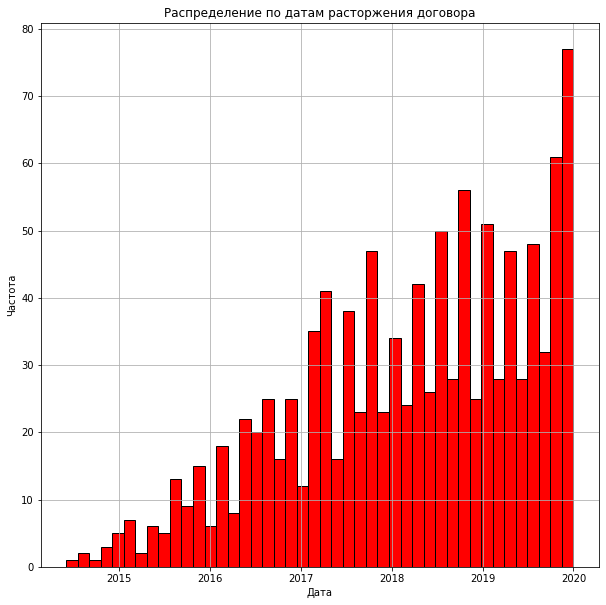

In [19]:
plt.figure(figsize=(10,10))
data['EndDate'].hist(bins=44, color='red', edgecolor='black')
plt.title('Распределение по датам расторжения договора')
plt.xlabel('Дата')
plt.ylabel('Частота')
plt.grid(True)

**Комментарий**: На графике видно, что рост оттока клиентов происходил постепенно, скорее всего это связано с расширением клиентской базы компании, однако на гафике есть выраженный пик уже в начале `2020`.

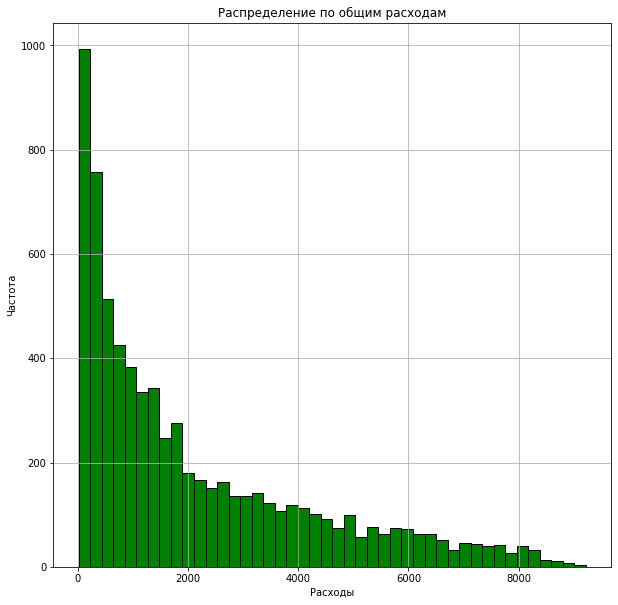

In [20]:
plt.figure(figsize=(10,10))
data['TotalCharges'].hist(bins=44, color='green', edgecolor='black')
plt.title('Распределение по общим расходам')
plt.xlabel('Расходы')
plt.ylabel('Частота')
plt.grid(True)

Text(0, 0.5, 'TotalCharges')

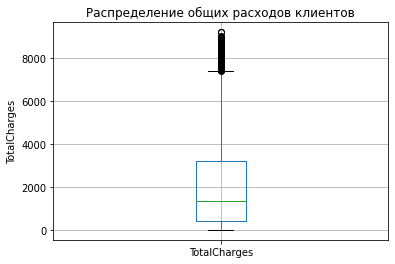

In [21]:
data.boxplot(column='TotalCharges')
plt.title('Распределение общих расходов клиентов')
plt.ylabel('TotalCharges')

**Комментарий**: На графике распределения общих расходов видно, что большинство клиентов не тратят более `1000`, количество клиентов имеющие более высокие расходы постепенно уменьшается и меньше всего клиентов тратящих более `6000` и `8000`.

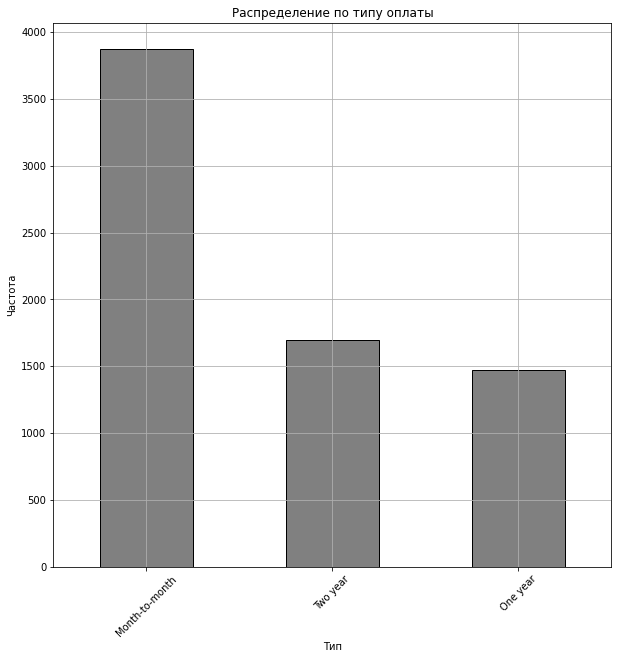

In [22]:
plt.figure(figsize=(10,10))
data['Type'].value_counts().plot(kind='bar', color='gray', edgecolor='black')
plt.title('Распределение по типу оплаты')
plt.xlabel('Тип')
plt.xticks(rotation=45)
plt.ylabel('Частота')
plt.grid(True)

**Комментарий**: Большинство клиентов используют ежемесячную оплату, а реже всего клиенты выбирают годовой способ оплаты

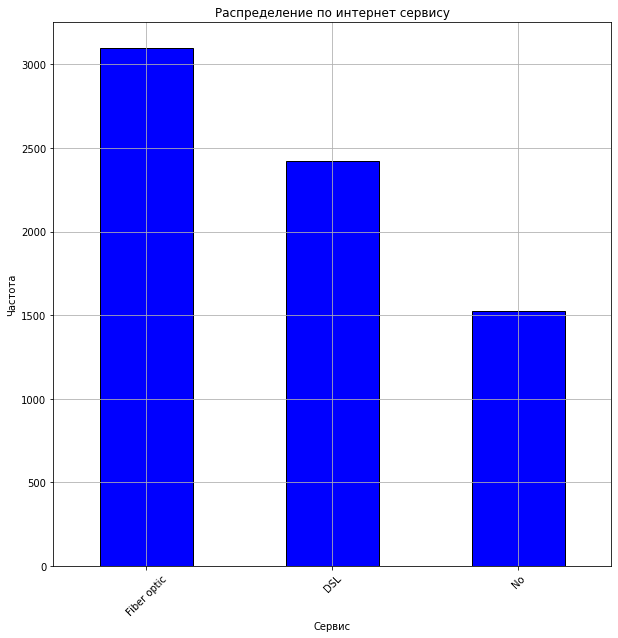

In [23]:
plt.figure(figsize=(10,10))
data['InternetService'].value_counts().plot(kind='bar', color='blue', edgecolor='black')
plt.title('Распределение по интернет сервису')
plt.xlabel('Сервис')
plt.xticks(rotation=45)
plt.ylabel('Частота')
plt.grid(True)

**Комментарий**: На графике видно, что большинство клиентов все таки имеют один из двух сервисов интернета и предпочетают сервис - `Fiber optic` и около `1500` клиентов не имеют интернет сервис.

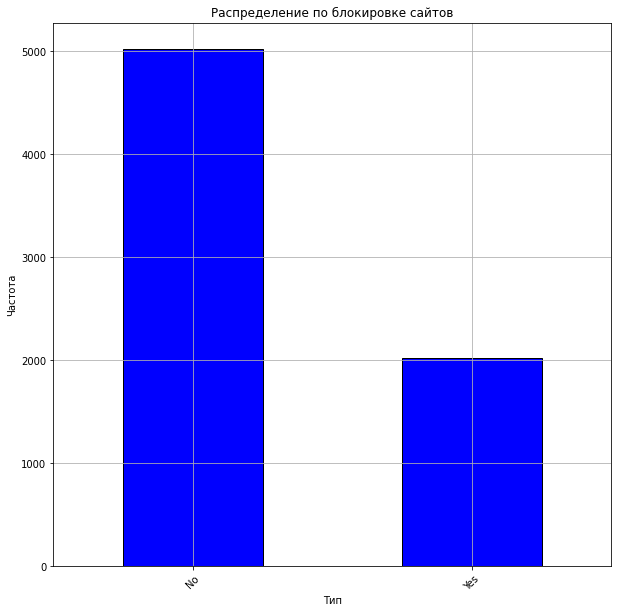

In [24]:
plt.figure(figsize=(10,10))
data['OnlineSecurity'].value_counts().plot(kind='bar', color='blue', edgecolor='black')
plt.title('Распределение по блокировке сайтов')
plt.xlabel('Тип')
plt.xticks(rotation=45)
plt.ylabel('Частота')
plt.grid(True)

**Комментарий**: Пользователей, которые подключают услугу блокировки опасных сайтов в `2.5` раза меньше (`2000`) чем тех кто отказывается от этой услуги.

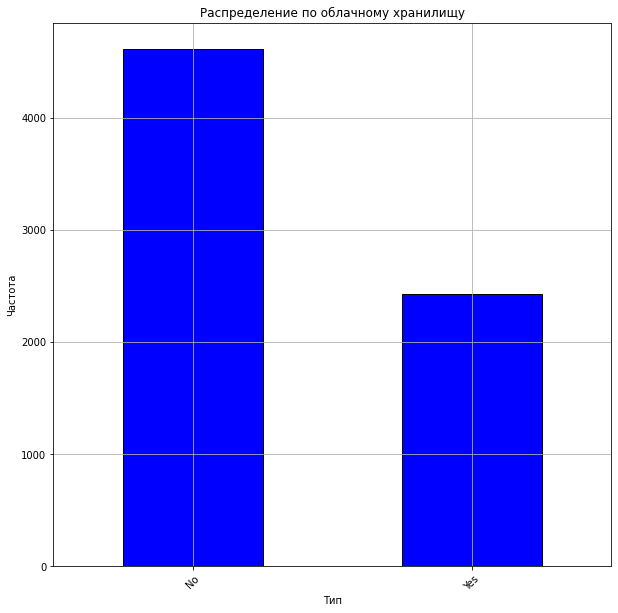

In [25]:
plt.figure(figsize=(10,10))
data['OnlineBackup'].value_counts().plot(kind='bar', color='blue', edgecolor='black')
plt.title('Распределение по облачному хранилищу')
plt.xlabel('Тип')
plt.xticks(rotation=45)
plt.ylabel('Частота')
plt.grid(True)

**Комментарий**: Людей подключающих услугу резервного копирования уже `больше`(около `2500`), чем тех кто подключает `блокировку опасных сайтов`

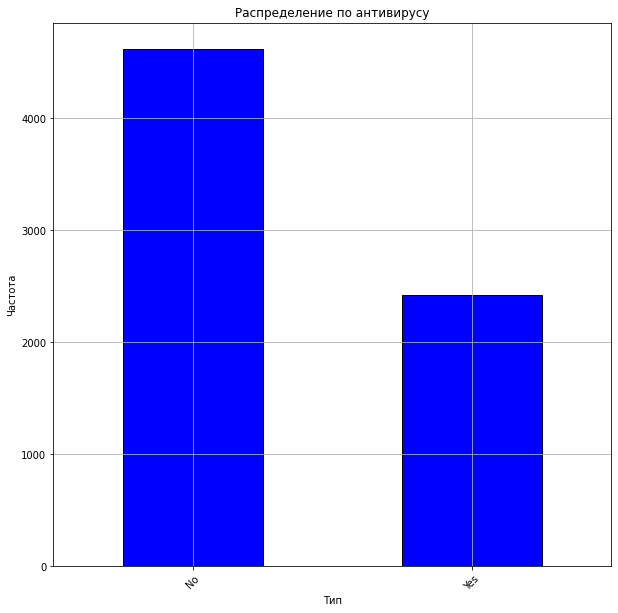

In [26]:
plt.figure(figsize=(10,10))
data['DeviceProtection'].value_counts().plot(kind='bar', color='blue', edgecolor='black')
plt.title('Распределение по антивирусу')
plt.xlabel('Тип')
plt.xticks(rotation=45)
plt.ylabel('Частота')
plt.grid(True)

**Комментарий**: Услуга `антивирус` пользуется примерно таким же спросом, что и услуга `резервного копирования в облако`.

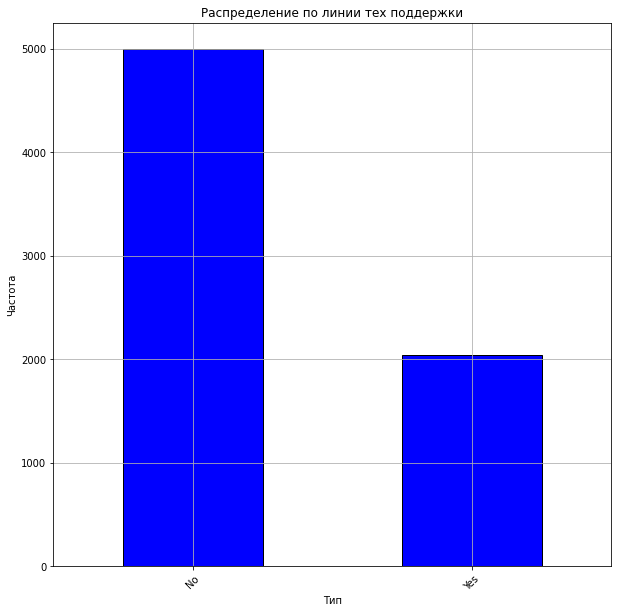

In [27]:
plt.figure(figsize=(10,10))
data['TechSupport'].value_counts().plot(kind='bar', color='blue', edgecolor='black')
plt.title('Распределение по линии тех поддержки')
plt.xlabel('Тип')
plt.xticks(rotation=45)
plt.ylabel('Частота')
plt.grid(True)

**Комментарий**: Клиентов использующих услугу `выделенной линии тех поддержки` в `2.5` раза меньше чем тех кто от нее отказался.

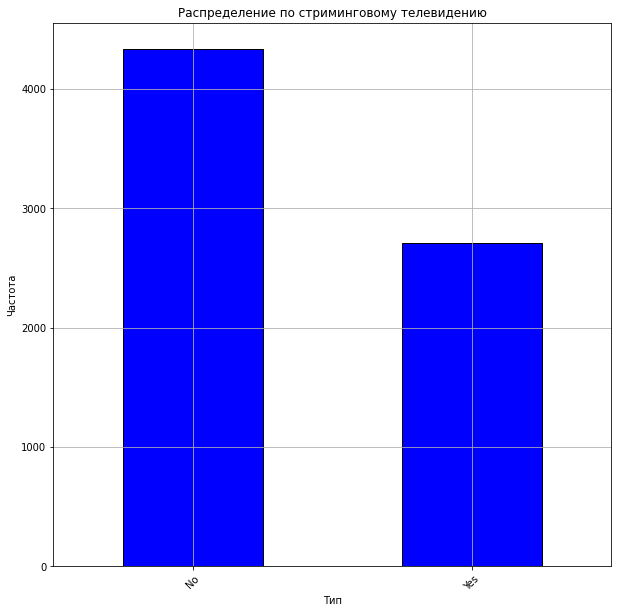

In [28]:
plt.figure(figsize=(10,10))
data['StreamingTV'].value_counts().plot(kind='bar', color='blue', edgecolor='black')
plt.title('Распределение по стриминговому телевидению')
plt.xlabel('Тип')
plt.xticks(rotation=45)
plt.ylabel('Частота')
plt.grid(True)

**Комментарий**: Пока что услуга `стриминговое телевидение` пользуется наибольшим спросом из всех доп услуг интернет сервиса - более `2500`

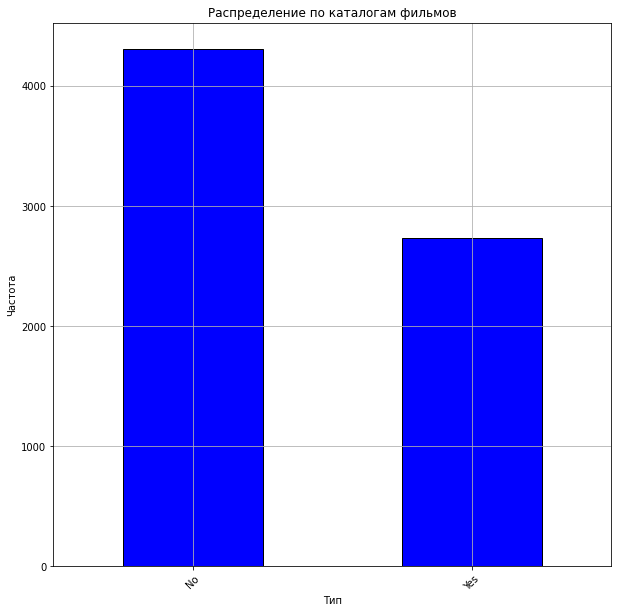

In [29]:
plt.figure(figsize=(10,10))
data['StreamingMovies'].value_counts().plot(kind='bar', color='blue', edgecolor='black')
plt.title('Распределение по каталогам фильмов')
plt.xlabel('Тип')
plt.xticks(rotation=45)
plt.ylabel('Частота')
plt.grid(True)

**Комментарий**: Услуга `каталог фильмов` пользуется примерно таким же спросом, что и услуга `стримингового телевидения`

### Создание новых признаков

In [30]:
data['Churn'] = data['EndDate'].notna().astype(int)

**Комментарий**: Добавлен бинарный признак, который показывает разорвал ли клиент контаркт или нет. `1` - значит разорвал, а `0` - значит `не` разорвал

In [31]:
data['EndDate_filled'] = data['EndDate'].fillna(pd.Timestamp('2020-02-01'))
data['tenure_months'] = ((data['EndDate_filled'] - data['BeginDate']) / np.timedelta64(1, 'M')).round(0)
data['tenure_months'] = data['tenure_months'].astype(int)

**Комментарий**: В этой ячейке, был добавлен столбец `EndDate_filled` где вместо пропусков мы поставили актуальную дату. После чего был добавлен еще один признак `tenure_month`, который отражает длительность контракта на момент `2020-02-01`

### Проверка корреляции

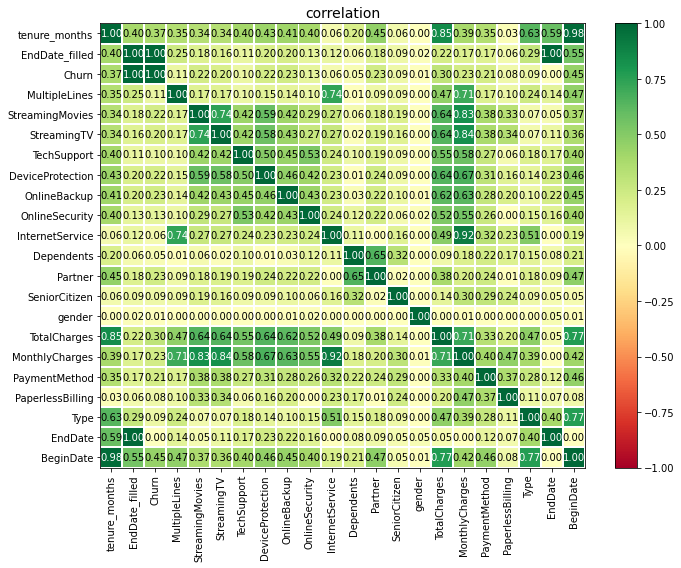

In [32]:
interval_cols = ['MonthlyCharges', 'TotalCharges', 'tenure_months']
data_corr = data.drop(columns=['customerID'])
phik_matrix = data_corr.phik_matrix(interval_cols=interval_cols)
plot_correlation_matrix(phik_matrix.fillna(0).values,
                        x_labels=phik_matrix.columns,
                        y_labels=phik_matrix.index,
                        figsize=(10, 8))

**Комментарий**:
```
Признаки tenure_months, TotalCharges и BeginDate заметно коррелируют с Churn — клиенты с длительными и дорогими контрактами реже расторгают договор.

Между MonthlyCharges и TotalCharges наблюдается высокая положительная корреляция (~0.71), что указывает на мультиколлинеарность — при моделировании один из признаков можно исключить.

BeginDate имеет хорошую корреляцию почти со всеми признаками кроме: SeniorCitizen, gender, PaperlessBilling и нулевую корреляцию с EndDate

Небольшая положительная связь Churn видна с признаками StreamingTV, StreamingMovies, MultipleLines и прочие доп услуги. Доп услуги также имеют хорошую корреляцию между собой

Слабая или нулевая корреляция у признаков gender, Partner, Dependents, значит они оказывают минимальное влияние на уход клиента. Также далее возможно исключение этих признаков.

Также заметно, что MonthlyCharges и TotalCharges довольно сильно коррелируют с доп услугами интернет сервиса
```

### Оценка дисбаланса классов

In [33]:
data['Churn'].value_counts(normalize=True)

0    0.843675
1    0.156325
Name: Churn, dtype: float64

**Комментарий**: В целевой признаке наблюдается явный дисбаланс классов - `84%` клиентов все еще остаются вместе с компанией и лишь `16%` разорвали контракт. Будем учитывать наличие дисбаланса классов во время обучения модели

## Подготовка к обучению модели

In [34]:
RANDOM_STATE = 61125

### Отбор признаков

In [35]:
features = [
    'tenure_months', 'MonthlyCharges',
    'Type', 'PaperlessBilling', 'PaymentMethod',
    'gender', 'SeniorCitizen', 'Partner', 'Dependents',
    'InternetService', 'OnlineSecurity', 'OnlineBackup',
    'DeviceProtection', 'TechSupport', 'StreamingTV',
    'StreamingMovies', 'MultipleLines'
]

**Комментарий**: Был проведен отбор признаков на основе анализа корреляции выше

### Кодировка данных

In [36]:
binary_cols = [
    'PaperlessBilling', 'Partner', 'Dependents', 
    'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
    'TechSupport', 'StreamingTV', 'StreamingMovies']

for col in binary_cols:
    data[col] = data[col].map({'Yes': 1, 'No': 0})

In [37]:

cat_cols = ['Type', 'PaymentMethod', 'gender', 'InternetService', 'MultipleLines']

encoder = OneHotEncoder(sparse=False, handle_unknown='error')
encoded = encoder.fit_transform(data[cat_cols])

encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names(cat_cols))

df = pd.concat([
    data.drop(columns=cat_cols).reset_index(drop=True),
    encoded_df.reset_index(drop=True)
], axis=1)

**Комментарий**: Все категориальные признаки закодированы.
Бинарные признаки (Yes/No) переведены в 0 и 1.

### Разбиение на выборки

In [38]:
X = df.drop(columns=['Churn', 'customerID', 'BeginDate', 'EndDate', 'EndDate_filled'], errors='ignore')
y = data['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE, stratify=y)
X_train = X_train.fillna(X_train.median())
X_test = X_test.fillna(X_train.median())

**Комментарий**: Создали выборки, удалили даты, id и целевой признак из датафрейма с входными признаками. После разьиения на выборки, еще раз заполнили пропуски медианным значением

## Обучение и тестирование 

### `LogisticRegression`

In [39]:
model_lr = LogisticRegression(random_state=RANDOM_STATE, max_iter=500, class_weight='balanced')
lr_score = cross_val_score(model_lr, X_train, y_train, cv=5, scoring='roc_auc')
display(lr_score.mean())

0.7731021854344172

**Комментарий**: Модель `LogsticRegression` показала значение `0.77` на метрике `ROC-AUC`

### `DecisionTreeClassifier`

In [40]:
model_dt = DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=7, class_weight='balanced')
dt_score = cross_val_score(model_dt, X_train, y_train, cv=5, scoring='roc_auc')
display(dt_score.mean())

0.7573664287218935

**Комментарий**: Модель `DecisionTreeClassifier` по метрике `ROC-AUC` имеет показатель - `0.76`

### LGBMClassifier

In [41]:
model_lc = LGBMClassifier(random_state=RANDOM_STATE, n_estimators=400, learning_rate=0.05, class_weight='balanced')
lc_score = cross_val_score(model_lc, X_train, y_train, cv=5, scoring='roc_auc')
display(lc_score.mean())

0.799829933892725

**Комментарий**: Модель `LGBMClassifier` показала на метрике `ROC-AUC` значение - `0.8`.

**Выбор модели**: Среди трех моделей, наибольшее значение метрики на кросс-валидации показала модель - `LGBMClassifier` с результатом - `0.8`, это модель и будет использоваться в дальнейшей работе

### Тест лучшей модели

In [42]:
model_lc.fit(X_train, y_train)
y_pred_proba_lc = model_lc.predict_proba(X_test)[:, 1]

roc_auc_lc = roc_auc_score(y_test, y_pred_proba_lc)
display('ROC-AUC для LGBM =', roc_auc_lc)
y_pred_lc= model_lc.predict(X_test)
accuracy_lc = accuracy_score(y_test, y_pred_lc)
display('Accuracy для LGBM =', accuracy_lc)

'ROC-AUC для LGBM ='

0.7919849079692042

'Accuracy для LGBM ='

0.7893989588263133

**Комментарий**: На тестовых данных модель `LGBMClassfier` по метрике `ROC-AUC` имеет показатель `0.79`, также по метрике `Accuracy` модель показала - `0.789`

## Анализ важности признаков

In [43]:
importance = model_lc.feature_importances_
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)

print(feature_importance)

                                    Feature  Importance
1                            MonthlyCharges        3187
2                              TotalCharges        2619
12                            tenure_months        1969
4                                   Partner         336
5                                Dependents         301
9                               TechSupport         291
0                          PaperlessBilling         249
8                          DeviceProtection         235
13                      Type_Month-to-month         221
7                              OnlineBackup         217
20                            gender_Female         216
15                            Type_Two year         209
3                             SeniorCitizen         207
11                          StreamingMovies         198
16  PaymentMethod_Bank transfer (automatic)         191
19               PaymentMethod_Mailed check         185
18           PaymentMethod_Electronic check     

**Комментарий**: Наиболее важными признаками для лучшей модели являются признаки отражающие: ежемесячные расходы пользователя, общие расходы и длительность контракта с компанией, остальные признаки в имеют важность в несколько раз ниже ранее перечисленных.

## Анализ матрицы ошибок

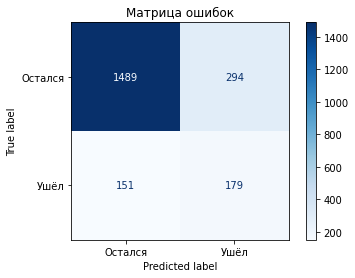

In [44]:
y_pred = model_lc.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Остался', 'Ушёл'])
disp.plot(cmap='Blues')
plt.title('Матрица ошибок')
plt.show()

**Комментарий**: Модель не замечает ухода клиента в `46%` случаев и верно предсказывает уход в остальных `54%`. Верно прдсказывает продолжение контракта в `84%` случаев и в остальных `16%` ошибочно предсказывает уход тех кто остался

## 🎯 Итоговый вывод по проекту «Прогноз оттока клиентов»

В рамках проекта была разработана и обучена модель машинного обучения, способная предсказывать вероятность оттока клиентов оператора связи **«ТелеДом»**.  

### 📊 Основные этапы работы

1. **Предобработка данных**  
   - Проведено объединение всех таблиц в единый датафрейм.  
   - Заполнены пропуски, удалены неинформативные признаки и преобразованы типы данных.  
   - Категориальные переменные закодированы методом *One-Hot Encoding*.  
   - Созданы новые признаки: длительность контракта и целевая переменная (факт расторжения договора).  

2. **Исследовательский анализ (EDA)**  
   - Изучено распределение признаков, взаимосвязи и корреляции.  
   - Определено, что на вероятность оттока влияют:  
     - расходы клиентов;  
     - длительность обслуживания;  
     - наличие дополнительных услуг (техподдержка, антивирус, ТВ и т.п.);  
     - способ оплаты и электронный счёт.  

3. **Построение и обучение моделей**  
   - Были протестированы три модели:  
     - **Логистическая регрессия**;  
     - **Дерево решений**;  
     - **LightGBM**.  
   - Для борьбы с дисбалансом классов использовался параметр `class_weight='balanced'`.  
   - Модели оценивались с помощью *кросс-валидации* и метрики **ROC-AUC**.  

4. **Оценка качества**  
   - Среднее значение **ROC-AUC** на кросс-валидации показало стабильность моделей.  
   - На тестовой выборке логистическая регрессия показала результат **ROC-AUC ≈ 0.79**, что соответствует хорошему уровню качества. 
   - По метрике **Accuracy = 0.789**. То есть модель верно дает предсказание в **79%** случаев.
   - По **матрице ошибок**:  
     - Модель верно определяет уход клиента в ~54% случаев;  
     - Верно распознаёт оставшихся клиентов в ~84% случаев;  
     - Допускает около 16% ложных тревог.  

5. **Интерпретация важности признаков**  
   - Наиболее значимыми оказались:  
     - длительность контракта;  
     - Общие расходы клиента;  
     - размер ежемесячной платы. 

---

### ✅ Вывод

Модель демонстрирует хорошее качество предсказаний и может быть эффективно применена для **прогноза оттока клиентов**.  
Её использование позволит компании:
- заранее выявлять клиентов с высоким риском ухода;
- предлагать им индивидуальные бонусы и акции;
- повысить удержание и сократить потери дохода.  